In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data

In [2]:
df_train = pd.read_csv('data/train.csv', index_col=0)
df_test = pd.read_csv('data/test.csv', index_col=0)

In [3]:
df_train['tt'] = 'train'
df_test['tt'] = 'test'

In [4]:
df = pd.concat([df_train,df_test])

## Feature Creation

In [5]:
df['dateTime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

In [6]:
df = df.set_index('dateTime')

In [7]:
df['dayofyear'] = df.index.dayofyear

In [29]:
df_train = df.loc[df['tt']=='train'].copy()

KeyError: 'tt'

In [9]:
df_coef = df_train.drop(columns={'tt'}).groupby('dayofyear').mean()[['surfaceHeight']]
df_train['coef'] = 0.0

for i in tqdm(range(df_coef.shape[0])):
    df_train.loc[df_train['dayofyear']==i,('coef')] = df_coef.reset_index().loc[i,('surfaceHeight')]

/var/folders/mm/04w0hy711n93_t1jwlzttfg00000gp/T/ipykernel_12879/3111347467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['coef'] = 0.0


  0%|          | 0/366 [00:00<?, ?it/s]

<Axes: xlabel='dayofyear', ylabel='coef'>

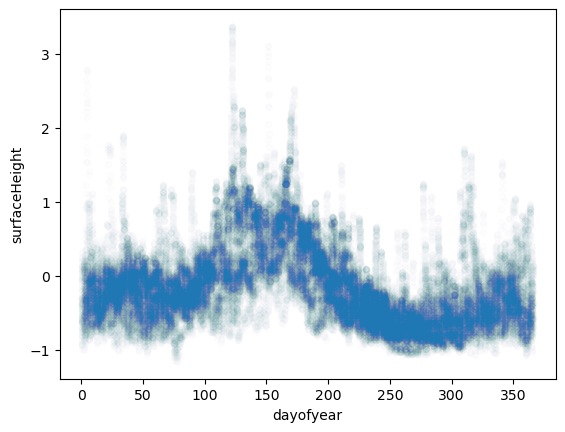

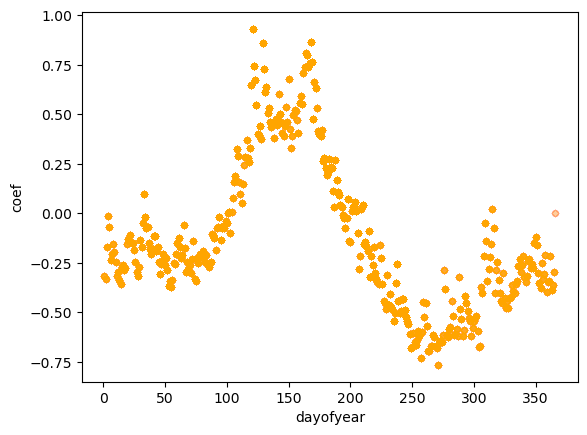

In [10]:
df_train.plot.scatter('dayofyear','surfaceHeight',alpha=0.008)
df_train.plot.scatter('dayofyear','coef',alpha=0.008,color='orange')

## Plotting

<Axes: xlabel='dateTime'>

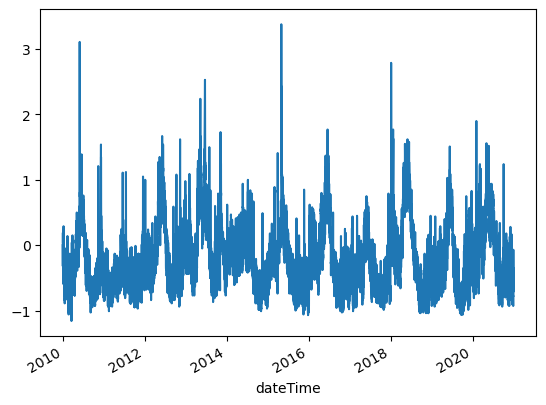

In [11]:
df['surfaceHeight'].plot()

<Axes: xlabel='dayofyear', ylabel='surfaceHeight'>

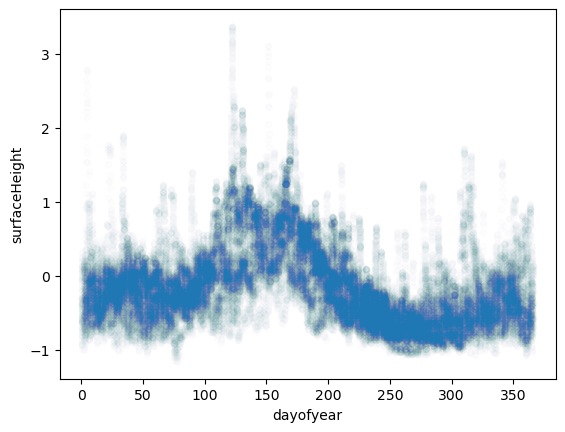

In [12]:
df.plot.scatter('dayofyear','surfaceHeight',alpha=0.008)

## Linear model

In [13]:
model = LinearRegression()

In [14]:
df_train = df_train.dropna()

In [15]:
df_train

,year,month,day,hour,minute,surfaceHeight,tt,dayofyear,coef
dateTime,,,,,,,,,
2010-01-01 00:12:00,2010,1,1,0,12,0.00,train,1,-0.316848
2010-01-01 00:59:00,2010,1,1,0,59,-0.03,train,1,-0.316848
2010-01-01 01:15:00,2010,1,1,1,15,-0.05,train,1,-0.316848
2010-01-01 01:18:00,2010,1,1,1,18,-0.07,train,1,-0.316848
2010-01-01 01:42:00,2010,1,1,1,42,-0.07,train,1,-0.316848
...,...,...,...,...,...,...,...,...,...
2020-12-31 14:05:00,2020,12,31,14,5,-0.68,train,366,0.000000
2020-12-31 16:20:00,2020,12,31,16,20,-0.70,train,366,0.000000
2020-12-31 18:14:00,2020,12,31,18,14,-0.69,train,366,0.000000


In [16]:
X_train = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']<2017]
y_train = df_train['surfaceHeight'].loc[df_train['year']<2017]

X_test = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']>=2017]
y_test = df_train['surfaceHeight'].loc[df_train['year']>=2017]

In [17]:
model.fit(X_train,y_train)

LinearRegression()

In [18]:
y_predict = model.predict(X_test)

<Axes: xlabel='dateTime'>

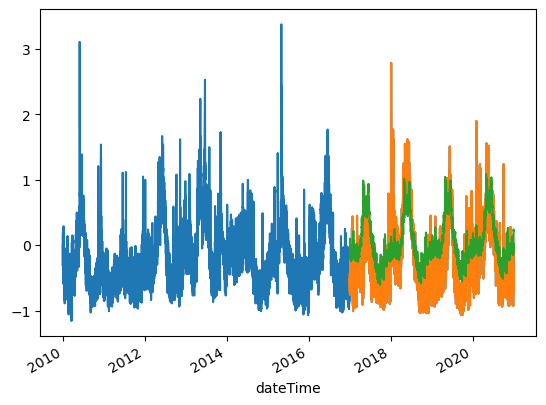

In [19]:
X_test['prediction'] = model.predict(X_test)
X_test['surfaceHeight'] = y_test

df_train['surfaceHeight'].plot()
X_test['surfaceHeight'].plot()
X_test['prediction'].plot()

<Axes: xlabel='dayofyear', ylabel='prediction'>

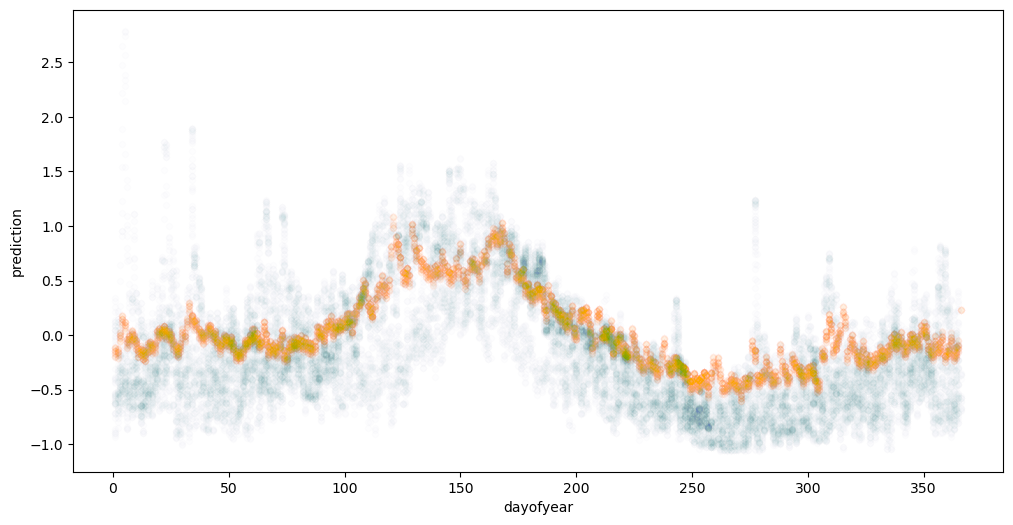

In [20]:
plt.figure(figsize=(12,6))
ax = plt.axes()
X_test.plot.scatter('dayofyear','surfaceHeight',alpha=0.008,ax=ax)
X_test.plot.scatter('dayofyear','prediction',alpha=0.008,ax=ax,color='orange')

## Decision tree

In [21]:
X_train = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']<2017]
y_train = df_train['surfaceHeight'].loc[df_train['year']<2017]

X_test = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']>=2017]
y_test = df_train['surfaceHeight'].loc[df_train['year']>=2017]

In [22]:
model2 = DecisionTreeRegressor()

model2.fit(X_train,y_train)

y_predict2 = model2.predict(X_test)

<Axes: xlabel='dateTime'>

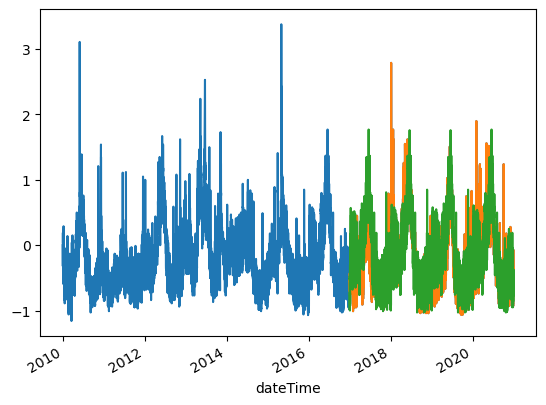

In [23]:
X_test['prediction2'] = model2.predict(X_test)
X_test['surfaceHeight'] = y_test

df_train['surfaceHeight'].plot()
X_test['surfaceHeight'].plot()
X_test['prediction2'].plot()

<Axes: xlabel='dayofyear', ylabel='prediction2'>

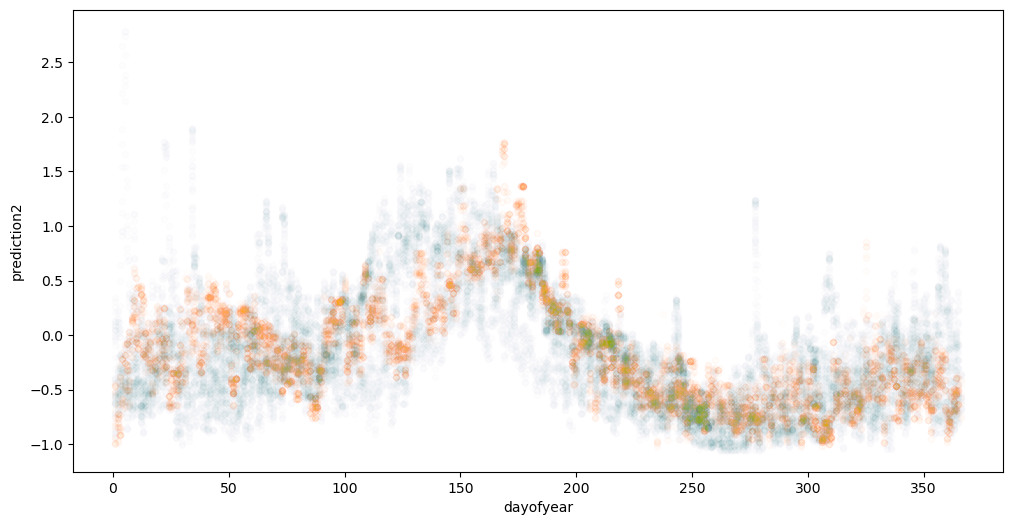

In [24]:
plt.figure(figsize=(12,6))
ax = plt.axes()
X_test.plot.scatter('dayofyear','surfaceHeight',alpha=0.008,ax=ax)
X_test.plot.scatter('dayofyear','prediction2',alpha=0.008,ax=ax,color='orange')

In [25]:
MAE1 = np.mean(np.sqrt(abs(y_predict-y_test)))

In [26]:
MAE2 = np.mean(np.sqrt(abs(y_predict2-y_test)))

In [27]:
print(MAE1,MAE2)

0.5266973605287445 0.5364441386410931


## Model XGboost